# Import relevant libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

# Import dataset & Preprocessing

In [2]:
dataset = pd.read_csv("pima-indians-diabetes.csv")
dataset

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
dataset.describe(include = "all")
# Пустых значений у нас нет

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Class
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


<AxesSubplot:>

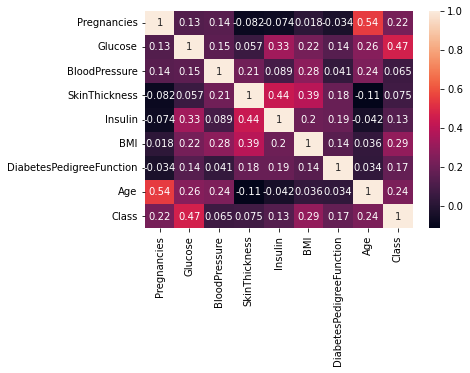

In [4]:
# Построим матрицу корреляций
sns.heatmap(dataset.corr(), annot=True)

In [5]:
# Самая большая степень корреляции у нас между переменными Pregnancies и Age, что в общем логично
# Также наблюдаем корреляцию между перемнными SkinThickness и Insulin, а также SkinThickness и BMI
# Однако думаю будет разумным оставить все переменные, как есть (так как у нас максимальная степень корреляции колеблется в районе 0.39-0.54 - средний уровень)
# Если будем наблюдать дальше сложности с эффективностью нашей модели, возможно вернемся к моменту с корреляцией. Пока что все ок.

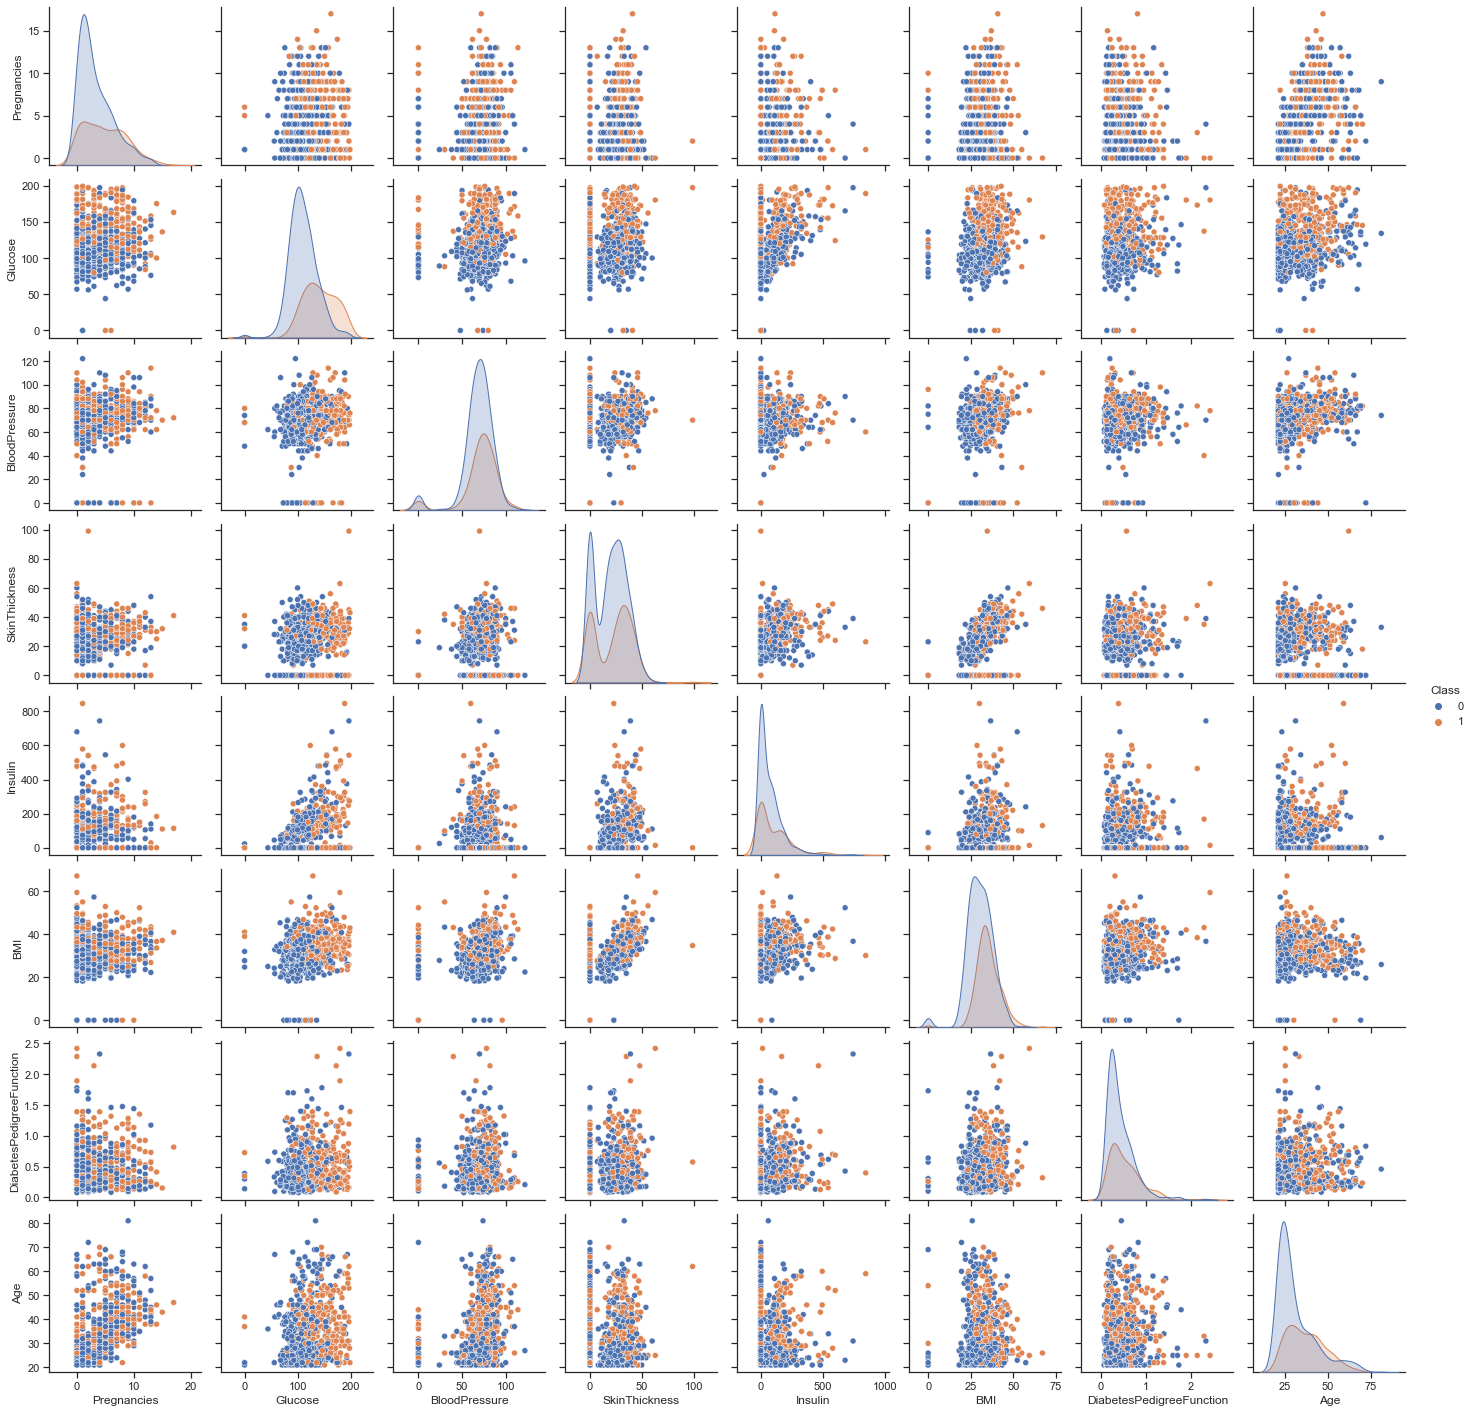

In [6]:
sns.set_theme(style="ticks")
sns.pairplot(dataset, hue="Class")
# Наши классы сбалансированы, распределения близки к нормальному

# Feature Scalling

In [7]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [9]:
# Сделаем Feature Scalling наших переменных
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [10]:
print(X_train)

[[-0.52639686 -1.15139792 -3.75268255 ... -4.13525578 -0.49073479
  -1.03594038]
 [ 1.58804586 -0.27664283  0.68034485 ... -0.48916881  2.41502991
   1.48710085]
 [-0.82846011  0.56687102 -1.2658623  ... -0.42452187  0.54916055
  -0.94893896]
 ...
 [ 1.8901091  -0.62029661  0.89659009 ...  1.76054443  1.981245
   0.44308379]
 [-1.13052335  0.62935353 -3.75268255 ...  1.34680407 -0.78487662
  -0.33992901]
 [-1.13052335  0.12949347  1.43720319 ... -1.22614383 -0.61552223
  -1.03594038]]


In [11]:
print(X_test)

[[ 0.68185612 -0.71402038 -0.61712658 ...  0.26073561 -0.11637247
   0.87809089]
 [-0.52639686 -0.27664283  0.30191569 ...  0.48053518 -0.954231
  -1.03594038]
 [-0.52639686 -0.40160784 -0.29275872 ... -0.15300476 -0.9245197
  -1.03594038]
 ...
 [ 1.28598261 -0.80774414  0.13973176 ...  0.62275843  0.04703966
   2.0961108 ]
 [-0.52639686  0.78555979  0.03160914 ... -0.51502758 -0.39268751
  -0.33992901]
 [ 1.28598261 -1.46381046  0.03160914 ...  0.42881763  0.70068816
   0.53008521]]


# Decision Trees Model with GridSearch

In [12]:
# Подберем параметры для нашей модели при помощи GridSearch метода (в качестве качественных характеристик используем метрики precision, recall и accuracy)
tuned_parameters = [
    {"criterion": ["gini"], "max_depth": [7, 10, 12, 15], "min_samples_leaf": [8, 10, 12, 15], 
     "min_samples_split": [2, 3, 4], "max_features": ['auto', 'sqrt', 'log2'], "class_weight": [None, 'balanced'], "random_state": [42]},
    {"criterion": ["entropy"], "max_depth": [7, 10, 12, 15], "min_samples_leaf": [8, 10, 12, 15], 
     "min_samples_split": [2, 3, 4], "max_features": ['auto', 'sqrt', 'log2'], "class_weight": [None, 'balanced'], "random_state": [42]}
]

scores = ["precision", "recall", "accuracy"]

for score in scores:
    clf = GridSearchCV(DecisionTreeClassifier(), tuned_parameters, scoring=score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:", score)
    print(clf.best_params_)
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]

    print("Detailed classification report:")
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))

Best parameters set found on development set: precision
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'random_state': 42}
Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        99
           1       0.64      0.55      0.59        55

    accuracy                           0.73       154
   macro avg       0.70      0.69      0.69       154
weighted avg       0.72      0.73      0.72       154

Best parameters set found on development set: recall
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'random_state': 42}
Detailed classification report:
The model is trained on the full development set.
The scores are computed on the f

In [13]:
# Лучшие гипперпараметры для нашей модели DecisionTrees такие:
# for precision - {'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2}
# for recall - {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2}
# for accuracy - {'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 2}

In [14]:
# Построим модель DecisionTrees с лучшими гипперпараметрами с позиции accuracy
classifier_DecisionTrees = DecisionTreeClassifier(criterion = 'entropy', class_weight = None, max_depth = 10, max_features = 'log2', 
                                                  min_samples_leaf = 10, min_samples_split = 2, random_state = 42)
classifier_DecisionTrees.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features='log2',
                       min_samples_leaf=10, random_state=42)

In [15]:
y_pred1_DecisionTrees = classifier_DecisionTrees.predict(X_test)

In [16]:
cm_DecTrees = confusion_matrix(y_test, y_pred1_DecisionTrees)
print(cm_DecTrees)
accuracy_score(y_test, y_pred1_DecisionTrees)

[[82 17]
 [23 32]]


0.7402597402597403

In [17]:
# Общая точность нашей модели составляет 74%, но также обратим внимание что показатели precision и recall на классе не больных людей гораздо выше чем на классе больных людей

In [18]:
# Визуализируем текстово наше полученное дерево решений
import sklearn.tree as sk_tree
text_representation_DecTrees = sk_tree.export_text(classifier_DecisionTrees)
print(text_representation_DecTrees)

|--- feature_7 <= -0.38
|   |--- feature_1 <= 0.21
|   |   |--- feature_5 <= -0.13
|   |   |   |--- feature_6 <= 0.60
|   |   |   |   |--- class: 0
|   |   |   |--- feature_6 >  0.60
|   |   |   |   |--- class: 0
|   |   |--- feature_5 >  -0.13
|   |   |   |--- feature_4 <= 0.16
|   |   |   |   |--- feature_7 <= -0.73
|   |   |   |   |   |--- feature_1 <= -0.35
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_1 >  -0.35
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_7 >  -0.73
|   |   |   |   |   |--- feature_2 <= -0.13
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_2 >  -0.13
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- feature_4 >  0.16
|   |   |   |   |--- feature_3 <= 0.69
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_3 >  0.69
|   |   |   |   |   |--- class: 0
|   |--- feature_1 >  0.21
|   |   |--- feature_7 <= -0.73
|   |   |   |--- feature_4 <= 1.54
|   |   |   |   |--- feature_6 <= -0.

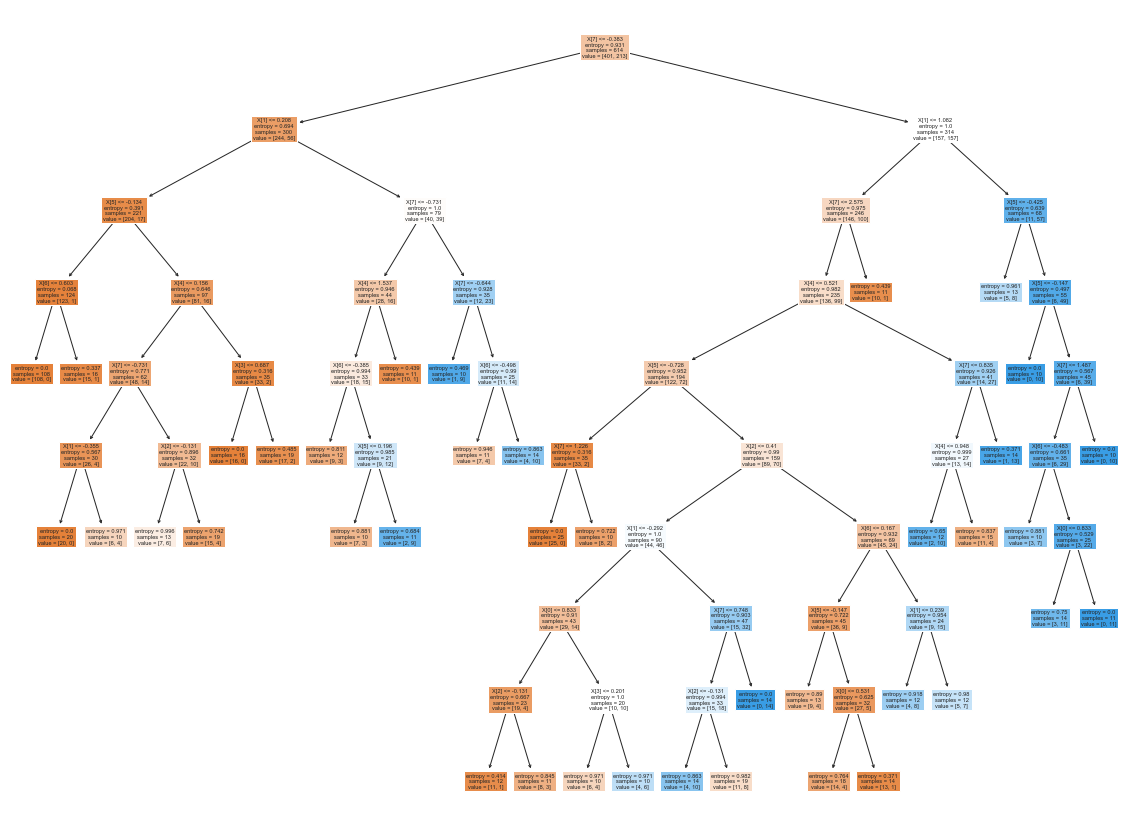

In [19]:
# Визуализируем более наглядно наше дерево решений
fig_DecTrees = plt.figure(figsize=(20,15))
_ = sk_tree.plot_tree(classifier_DecisionTrees, filled=True)

# Random Forest Model with GridSearch

In [20]:
# Подберем параметры для нашей модели при помощи GridSearch метода (в качестве качественных характеристик используем только метрику accuracy для лучшей производительности)
tuned_parameters2 = [
    {"criterion": ["gini", "entropy"], "n_estimators": [10, 20, 30], "max_depth": [5, 10, 15], "min_samples_leaf": [3, 5, 7],
     "max_features": ['auto', 'sqrt', 'log2'], "bootstrap": [True, False], "warm_start": [True, False], "class_weight": [{0: 1, 1: 1}, {0: 1, 1: 2}, {0: 2, 1: 1}], "random_state": [42]}
]

scores2 = "accuracy"

clf = RandomForestClassifier()
    
clf_grid = GridSearchCV(estimator = clf, param_grid = tuned_parameters2, scoring = scores2, cv = 3, n_jobs = -1, verbose = 2, refit = bool)
    
clf_grid.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf_grid.best_params_)

print("Detailed classification report:")
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
y_true, y_pred = y_test, clf_grid.predict(X_test)
print(classification_report(y_true, y_pred))

Fitting 3 folds for each of 1944 candidates, totalling 5832 fits
Best parameters set found on development set:
{'bootstrap': True, 'class_weight': {0: 1, 1: 1}, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 3, 'n_estimators': 10, 'random_state': 42, 'warm_start': False}
Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

           0       0.80      0.88      0.84        99
           1       0.73      0.60      0.66        55

    accuracy                           0.78       154
   macro avg       0.77      0.74      0.75       154
weighted avg       0.78      0.78      0.77       154



In [21]:
# Лучшие гипперпараметры для нашей модели RandomForest такие:
# for accuracy - {'bootstrap': True, 'class_weight': {0: 1, 1: 1}, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 3, 'n_estimators': 10, 'warm_start': False}

In [22]:
# Построим модель RandomForest с лучшими гипперпараметрами с позиции accuracy
classifier_RandomForest = RandomForestClassifier(criterion = 'gini', n_estimators = 10, bootstrap = True, warm_start = False, class_weight = {0: 1, 1: 1}, max_depth = 5, max_features = "auto", min_samples_leaf = 3, random_state = 42)
classifier_RandomForest.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 1}, max_depth=5,
                       min_samples_leaf=3, n_estimators=10, random_state=42)

In [23]:
y_pred1_RandomForest = classifier_RandomForest.predict(X_test)

In [24]:
cm_RandomForest = confusion_matrix(y_test, y_pred1_RandomForest)
print(cm_RandomForest)
accuracy_score(y_test, y_pred1_RandomForest)

[[87 12]
 [22 33]]


0.7792207792207793

In [25]:
# Точность нашей модели возросла на 4% и составила 78%, но в большинстве своем зачастую повышения точности класса не больных
# Если размышлять с позиции врача, то ситуация у нас не сильно хорошая, так как мы плохо предсказываем больной ли человек, и наоборот хорошо предсказываем, если человек не больной
# Постараемся дальше улучшить точность нашей модели при помощи других методов ансамблирования

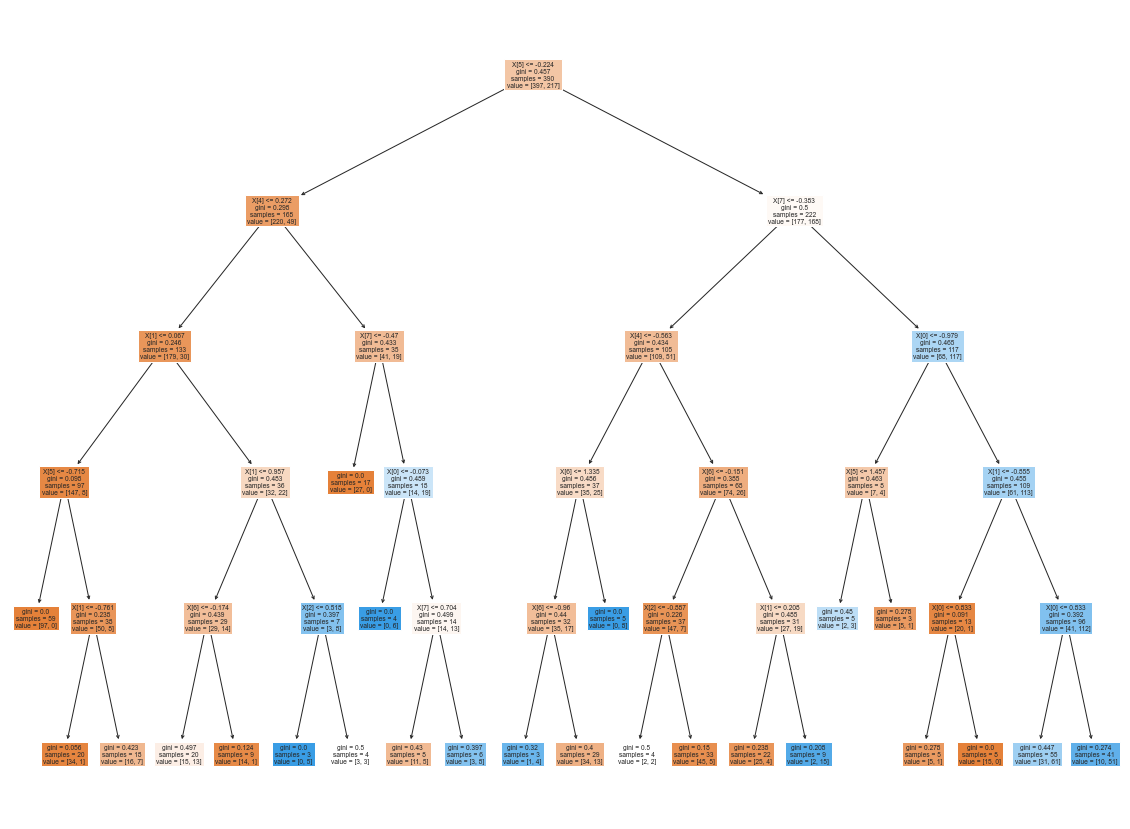

In [26]:
# Для наглядности мы можем визуализировать например первое дерево используемое в случайных деревьях
# В целом визуализировать случайный лес полностью на одной диаграмме не представляется возможным, мы можем визуализировать конкретные деревья из этого леса и их изучить (например в нашем примере - 10 деревьев. их можно визуализировать и подробно изучить с целью изучения закономерностей)
fig_RandomForest_FirstTree = plt.figure(figsize=(20,15))
_ = sk_tree.plot_tree(classifier_RandomForest.estimators_[0], filled=True)

# Первое дерево вышло достаточно симметричное, также видим, что алгоритм его немного оббрезал снизу если сравнивать с обычным деревом решений
# Но думаю есть деревья, которые достаточно значительно отличаются от него по своей структуре

In [27]:
# Изучим вопрос касательно важности признаков в нашей модели случайного леса
from sklearn.datasets import make_regression
importance = classifier_RandomForest.feature_importances_

In [28]:
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.06278
Feature: 1, Score: 0.36479
Feature: 2, Score: 0.04052
Feature: 3, Score: 0.05108
Feature: 4, Score: 0.03966
Feature: 5, Score: 0.21966
Feature: 6, Score: 0.09272
Feature: 7, Score: 0.12878


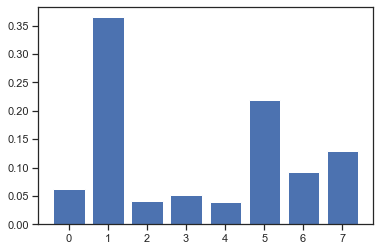

In [29]:
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [30]:
dataset.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [31]:
# Итого, самые важные признаки - это Glucose, BMI and Age
# Менее важные признаки - Insulin, BloodPressure and SkinThickness

# Final Ensemle Model with GridSearch

In [32]:
# Теперь попробуем улучшить нашу модель за счет комбинации четтырех моделей классификации - Логистическая регрессия, Опорные вектора, Дерево Решений и Случайный лес
# Наша первоочередная задача - улучшить наши предсказания по больным людям
# Для начала попробуем запустить нашу модель с коробки без подбора гипперпараметров
clf1 = LogisticRegression(random_state = 42)
clf2 = DecisionTreeClassifier(random_state = 42)
clf3 = SVC(random_state = 42)
clf4 = RandomForestClassifier(random_state = 42)

In [33]:
ensemble_clf1 = VotingClassifier(estimators=[('Logistic', clf1), ('DecisionTrees', clf2), ('SVM', clf3), ('RandomForest', clf4)], voting='hard')
ensemble_clf1.fit(X_train, y_train)

VotingClassifier(estimators=[('Logistic', LogisticRegression(random_state=42)),
                             ('DecisionTrees',
                              DecisionTreeClassifier(random_state=42)),
                             ('SVM', SVC(random_state=42)),
                             ('RandomForest',
                              RandomForestClassifier(random_state=42))])

In [34]:
y_pred_ensemble_clf1 = ensemble_clf1.predict(X_test)

In [35]:
cm_ensemble_clf1 = confusion_matrix(y_test, y_pred_ensemble_clf1)
print(cm_ensemble_clf1)
accuracy_score(y_test, y_pred_ensemble_clf1)

[[83 16]
 [19 36]]


0.7727272727272727

In [36]:
# Наша точность составляет на 77%, что на 1% меньше чем в модели со случайным лесом, но уже заметно сразу улучшение предсказаний по болным людям. Это хорошо.

In [37]:
# Попробуем настроить гипперпараметры, чтобы наша модель работала еще лучше
# Пожертвуем немного производительностью чтобы в целях изучения посмотреть на большее число комбинаций гиперпараметров нашей модели
ensemble_clf2 = VotingClassifier(estimators=[('Logistic', clf1), ('DecisionTrees', clf2), ('SVM', clf3), ('RandomForest', clf4)], voting='hard')

params = [{'Logistic__C': [0.1, 0.3, 0.7], 'Logistic__max_iter': [100, 1000], 'DecisionTrees__criterion': ['gini', 'entropy'], 'DecisionTrees__max_features': ['sqrt', 'log2'], 
          'DecisionTrees__max_depth': [10, 20, 30], 'SVM__kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'RandomForest__n_estimators': [10, 20, 30], 'RandomForest__criterion': ['gini', 'entropy'], 
          'RandomForest__max_depth': [10, 20, 30]}]

scores3 = ["accuracy", "precision", "recall"]

for score in scores3:
    grid_ensemble = GridSearchCV(estimator=ensemble_clf2, param_grid=params, scoring = scores3, cv = 3, n_jobs = -1, verbose = 2, refit = bool)

    grid_ensemble.fit(X_train, y_train)

    print("Best parameters set found on development set:", score)
    print(grid_ensemble.best_params_)

    print("Detailed classification report:")
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    y_true, y_pred = y_test, grid_ensemble.predict(X_test)
    print(classification_report(y_true, y_pred))

Fitting 3 folds for each of 5184 candidates, totalling 15552 fits
Best parameters set found on development set: accuracy
{'DecisionTrees__criterion': 'gini', 'DecisionTrees__max_depth': 10, 'DecisionTrees__max_features': 'sqrt', 'Logistic__C': 0.1, 'Logistic__max_iter': 100, 'RandomForest__criterion': 'gini', 'RandomForest__max_depth': 10, 'RandomForest__n_estimators': 10, 'SVM__kernel': 'poly'}
Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

           0       0.78      0.89      0.83        99
           1       0.73      0.55      0.62        55

    accuracy                           0.77       154
   macro avg       0.76      0.72      0.73       154
weighted avg       0.76      0.77      0.76       154

Fitting 3 folds for each of 5184 candidates, totalling 15552 fits
Best parameters set found on development set: precision
{'DecisionTrees__c

In [38]:
# Лучшая комбинация гиперпараметров для нашей модели (для всех трех качественных параметров  у нас все совпало):
# {'DecisionTrees__criterion': 'gini', 'DecisionTrees__max_depth': 10, 'DecisionTrees__max_features': 'sqrt', 'Logistic__C': 0.1, 'Logistic__max_iter': 100, 'RandomForest__criterion': 'gini', 'RandomForest__max_depth': 10, 'RandomForest__n_estimators': 10, 'SVM__kernel': 'poly'}
# Предполагаю, что можно улучшить этот показатель на 1-2%, но это нужно перебрать больше чем 15 тыс. комбинаций

In [39]:
# Посчитаем confusion matrix и сравним с результатами модели с коробки
y_pred_grid_ensemble = grid_ensemble.predict(X_test)

In [40]:
cm_grid_ensemble = confusion_matrix(y_test, y_pred_grid_ensemble)
print(cm_grid_ensemble)
accuracy_score(y_test, y_pred_grid_ensemble)

[[88 11]
 [25 30]]


0.7662337662337663

In [41]:
# Точность также на уровне около 77%, но с предсказанием конкретно только больных людей у нас все стало намного хуже
# В нашем случае с коробки модель работает лучше (но опять же причина думаю в том, что не нашли лучшую комбинацию)
# В качестве ФИНАЛЬНОГО результат возьмем ансамблирующую модель с гипперпараметрами по умолчанию

In [42]:
# Ответ на вопрос - Используйте ещё один метод ансамблирования из sklearn.ensemble (Stacking, Bagging, Voting). Как он работает? 
# В данной работе я использовал метод Voting. Основные моменты:
# VotingClassifier - это ансамблевый алгоритм машинного обучения.
# VotingClassifier, являющийся отличным инструментом использования сразу нескольких, не похожих между собой, моделей машинного обучения и их объединения в один классификатор. 
# Это позволяет снизить риск переобучения, а также неправильной интерпретации результатов какой-либо одной отдельно взятой модели.
# In classification, a hard voting ensemble involves summing the votes for crisp class labels from other models and predicting the class with the most votes. 
# A soft voting ensemble involves summing the predicted probabilities for class labels and predicting the class label with the largest sum probability.